In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import pandas as pd

In [8]:
df_alert_date = pd.read_csv("./訓練資料集_first/train_x_alert_date.csv")
df_custinfo = pd.read_csv("./訓練資料集_first/public_train_x_custinfo_full_hashed.csv")
# df_dp = pd.read_csv("./訓練資料集_first/public_train_x_dp_full_hashed.csv")
df_answer = pd.read_csv("./訓練資料集_first/train_y_answer.csv")
data = df_alert_date.merge(df_custinfo, how= 'left', on = 'alert_key')
# data = data.merge(df_dp['cust_id'].value_counts(), how = 'left', left_on='cust_id', right_index=True)
data = data.merge(df_answer, how= 'left', on = 'alert_key')
alert_times_dict = {}
alert_times_list = []
for i, row in data.iterrows():
    if alert_times_dict.__contains__(row.cust_id):
        alert_times_list.append(alert_times_dict[row.cust_id])
        alert_times_dict[row.cust_id] += 1
    else :
        alert_times_list.append(0)
        alert_times_dict[row.cust_id] = 1
data['alert_times'] = alert_times_list
data

,alert_key,date,cust_id,risk_rank,occupation_code,total_asset,AGE,sar_flag,alert_times
0,171189,0,972ee157e63316e8a50dd489bc93730a3ee8a8959d5c6b...,1,17.0,375576.0,4,0,0
1,171202,0,a10ab33f90926fb18d7bb5e78034d7f04a1fbed95b7951...,3,12.0,2717416.0,2,0,0
2,171599,0,3433ecc068ed1c9e2f5037cab5d42d7b901e9bd624c1fb...,1,12.0,326517.0,4,0,0
3,171737,0,a0861608615a9365d90f4ba0a813c0ea0471987f925c8b...,3,14.0,1014759.0,4,0,0
4,171142,0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,0
...,...,...,...,...,...,...,...,...,...
23901,352132,364,c49b33d1fde790ec03584672903f296e486615adfdc989...,1,19.0,3218731.0,3,0,2
23902,352125,364,0c2dc5fedc3689abf5ff4be14fe8fea8d23d22068297c2...,3,19.0,928963.0,3,0,1
23903,352080,364,1a93961c8fa830a1f32f5316b44f4964d65397f0311b11...,2,9.0,69080.0,6,0,6
23904,352075,364,9586b80d3ad1d74c0a1efe792cae2ecd073243fb01ed33...,3,3.0,262604.0,6,0,4


In [9]:

df_ccba = pd.read_csv("./訓練資料集_first/public_train_x_ccba_full_hashed.csv")
data = data.merge(df_ccba, how = 'outer', left_on=['cust_id', 'date'], right_on=['cust_id', 'byymm'])
data['date'] = data[['date', 'byymm']].apply(lambda x : x[0] if pd.notna(x[0]) else x[1], axis = 1)
data.drop('byymm', axis = 1,inplace=True)
data = data.sort_values(['cust_id','alert_key']).reset_index(drop= True)
data.fillna(method='ffill', inplace = True)
data.fillna(method='bfill', inplace = True)
data = data.sort_values(['cust_id', 'date'])
data

,alert_key,date,cust_id,risk_rank,occupation_code,total_asset,AGE,sar_flag,alert_times,lupay,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
1,195913.0,0.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,17.0,32758.0,3.0,0.0,0.0,3920.0,134614.0,32316.0,0.0,0.0,3148.0,16576.0,0.0
2,195913.0,30.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,17.0,32758.0,3.0,0.0,0.0,16576.0,134614.0,22280.0,0.0,0.0,3148.0,8653.0,0.0
0,195913.0,53.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,17.0,32758.0,3.0,0.0,0.0,3920.0,134614.0,32316.0,0.0,0.0,3148.0,16576.0,0.0
3,195913.0,61.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,17.0,32758.0,3.0,0.0,0.0,8653.0,134614.0,14771.0,0.0,0.0,3148.0,5045.0,0.0
4,195913.0,91.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,17.0,32758.0,3.0,0.0,0.0,5045.0,134614.0,10954.0,0.0,0.0,3148.0,4334.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82534,303894.0,334.0,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,1.0,14.0,458455.0,5.0,0.0,0.0,19766.0,781570.0,26360.0,0.0,0.0,1142.0,2568.0,0.0
82535,303894.0,365.0,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,1.0,14.0,458455.0,5.0,0.0,0.0,2591.0,781570.0,23903.0,0.0,0.0,5199.0,5199.0,0.0
82536,350878.0,363.0,fff322436b556032e07690f12456d9eff3588c269d6210...,2.0,19.0,591218.0,3.0,0.0,0.0,2591.0,781570.0,23903.0,0.0,0.0,5199.0,5199.0,0.0
82537,351619.0,364.0,fff322436b556032e07690f12456d9eff3588c269d6210...,2.0,19.0,624147.0,3.0,0.0,1.0,2591.0,781570.0,23903.0,0.0,0.0,5199.0,5199.0,0.0


In [10]:
data = data.astype({
    'alert_key' : "category",
    'date' : "category",
    'cust_id' : "category", 
    'risk_rank': "category", 
    'occupation_code': "category",
    'total_asset' : "int32", 
    'AGE' : 'int32',
    'sar_flag': "category", 
    'alert_times': "category", 
    'lupay' : "int32", 
    'cycam' : "int32",
    'usgam' : "int32", 
    'clamt' : "int32", 
    'csamt' : "int32", 
    'inamt' : "int32", 
    'cucsm' : "int32", 
    'cucah' : "int32"
})

In [17]:
training_feature = ['cycam', 'total_asset', 'occupation_code', 'usgam', 'cucsm',
       'alert_times', 'inamt', 'lupay', 'AGE']
X_train, X_test, y_train, y_test = train_test_split(data[training_feature], data['sar_flag'], test_size=0.3, random_state=1)

0.5576895394434966


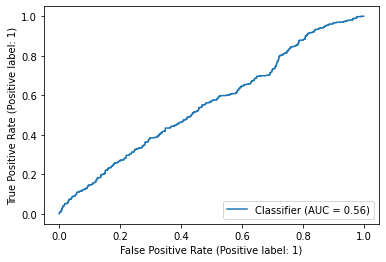

In [18]:
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_train, y_train)
print(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
RocCurveDisplay.from_predictions(y_train, clf.predict_proba(X_train)[:, 1])
plt.show()

0.5581158884699838


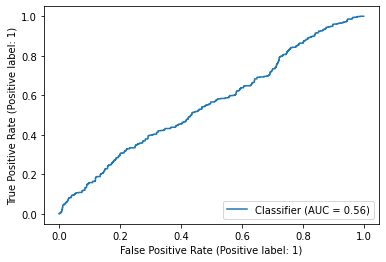

In [19]:
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
RocCurveDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:, 1])
plt.show()

# Output

In [ ]:
# df_alert_date = pd.read_csv("./訓練資料集_first/train_x_alert_date.csv")
df_alert_date = pd.read_csv("./訓練資料集_first/public_x_alert_date.csv")
df_custinfo = pd.read_csv("./訓練資料集_first/public_train_x_custinfo_full_hashed.csv")
# df_dp = pd.read_csv("./訓練資料集_first/public_train_x_dp_full_hashed.csv")
df_answer = pd.read_csv("./訓練資料集_first/train_y_answer.csv")
data = df_alert_date.merge(df_custinfo, how= 'left', on = 'alert_key')
# data = data.merge(df_dp['cust_id'].value_counts(), how = 'left', left_on='cust_id', right_index=True)
data = data.merge(df_answer, how= 'left', on = 'alert_key')
alert_times_dict = {}
alert_times_list = []
for i, row in data.iterrows():
    if alert_times_dict.__contains__(row.cust_id):
        alert_times_list.append(alert_times_dict[row.cust_id])
        alert_times_dict[row.cust_id] += 1
    else :
        alert_times_list.append(0)
        alert_times_dict[row.cust_id] = 1
data['alert_times'] = alert_times_list
data

,alert_key,date,cust_id,risk_rank,occupation_code,total_asset,AGE,sar_flag,alert_times
0,352342,365,7629f010080267f680a4ca9c6cac71c4d4d86933dcc7ed...,1,17.0,506366.0,3,NaN,0
1,352866,365,e50deb3f2f87bf45e04940303f80c96929c836b0b03f54...,1,12.0,309830.0,4,NaN,0
2,352696,365,c6def618ad861703c025be4f41bdf7569310228ae93aef...,1,2.0,444392.0,3,NaN,0
3,352330,365,96d70b798f211393cfbcb83a8acd19f3e8c9c5c205960a...,1,19.0,143930.0,4,NaN,0
4,352683,365,40fa92acb89d1ebb319f0f200d31a5fcbdfcbd8ad432d7...,3,17.0,2112.0,2,NaN,0
...,...,...,...,...,...,...,...,...,...
1840,364472,393,bdda3ef79c5f052fd281c9f28f50a25977444eceaf9751...,3,19.0,2390889.0,4,NaN,5
1841,364788,393,0ef49d08b4af68e9cb2b2aa63198699ee7dc7b5e1c4550...,2,19.0,28681.0,2,NaN,0
1842,364673,393,f8ce663f765e2459578d285a032a16046fba0b2bba8e12...,1,19.0,213486.0,6,NaN,0
1843,364626,393,1729de666fbfd3bd42133e8226f5ade5709ef141d8e0b7...,1,19.0,2913.0,2,NaN,3


In [21]:

df_ccba = pd.read_csv("./訓練資料集_first/public_train_x_ccba_full_hashed.csv")
data = data.merge(df_ccba, how = 'outer', left_on=['cust_id', 'date'], right_on=['cust_id', 'byymm'])
data['date'] = data[['date', 'byymm']].apply(lambda x : x[0] if pd.notna(x[0]) else x[1], axis = 1)
data.drop('byymm', axis = 1,inplace=True)
data = data.sort_values(['cust_id','alert_key']).reset_index(drop= True)
data.fillna(method='ffill', inplace = True)
data.fillna(method='bfill', inplace = True)
data = data.sort_values(['cust_id', 'date'])
data

,alert_key,date,cust_id,risk_rank,occupation_code,total_asset,AGE,sar_flag,alert_times,lupay,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,361270.0,0.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,19.0,2924860.0,5.0,NaN,0.0,3920.0,134614.0,32316.0,0.0,0.0,3148.0,16576.0,0.0
1,361270.0,30.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,19.0,2924860.0,5.0,NaN,0.0,16576.0,134614.0,22280.0,0.0,0.0,3148.0,8653.0,0.0
2,361270.0,61.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,19.0,2924860.0,5.0,NaN,0.0,8653.0,134614.0,14771.0,0.0,0.0,3148.0,5045.0,0.0
3,361270.0,91.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,19.0,2924860.0,5.0,NaN,0.0,5045.0,134614.0,10954.0,0.0,0.0,3148.0,4334.0,0.0
4,361270.0,122.0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1.0,19.0,2924860.0,5.0,NaN,0.0,4334.0,134614.0,7544.0,0.0,0.0,3148.0,4396.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60863,360085.0,275.0,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,3.0,17.0,21647.0,4.0,NaN,2.0,61927.0,781570.0,37297.0,0.0,0.0,0.0,37276.0,0.0
60864,360085.0,306.0,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,3.0,17.0,21647.0,4.0,NaN,2.0,37297.0,781570.0,45413.0,0.0,0.0,0.0,19766.0,0.0
60865,360085.0,334.0,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,3.0,17.0,21647.0,4.0,NaN,2.0,19766.0,781570.0,26360.0,0.0,0.0,1142.0,2568.0,0.0
60866,360085.0,365.0,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,3.0,17.0,21647.0,4.0,NaN,2.0,2591.0,781570.0,23903.0,0.0,0.0,5199.0,5199.0,0.0


In [43]:
data['probability'] = clf.predict_proba(data[training_feature])[:,-1]
data_output = df_alert_date.merge(data, how = 'left', on = ['alert_key', 'date'])
df_alert_date

,alert_key,date
0,352342,365
1,352866,365
2,352696,365
3,352330,365
4,352683,365
...,...,...
1840,364472,393
1841,364788,393
1842,364673,393
1843,364626,393


In [44]:
data_output = data_output[['alert_key', 'probability']].drop_duplicates(subset='alert_key').reset_index(drop= True)
data_output

,alert_key,probability
0,352342,0.077143
1,352866,0.151075
2,352696,0.069411
3,352330,0.009518
4,352683,0.000024
...,...,...
1840,364472,0.014441
1841,364788,0.090806
1842,364673,0.012961
1843,364626,0.062557


In [47]:
df_sample = pd.read_csv('./訓練資料集_first/預測的案件名單及提交檔案範例.csv')
df_sample.merge(data_output, how='left', on = 'alert_key')

,alert_key,probability_x,probability_y
0,357307,0.000017,0.155021
1,376329,0.000324,NaN
2,373644,0.000372,NaN
3,357668,0.000489,0.044807
4,354443,0.000526,0.061834
...,...,...,...
3845,364485,0.997702,0.032527
3846,363155,0.998987,0.043122
3847,368710,0.999694,NaN
3848,358067,0.999821,0.042447


In [45]:
data_output[['alert_key', 'probability']].to_csv('./output/output1201.csv',index = False)